# Occupancy detection using Electricity demand and GeoMA
This notebook demonstrates how to infere the occupancy schedule of a dwelling based on the Geometric Moving Average (GeoMA) of its electricity demand, following the implementation by Becker et al. (2017).

## Imports
Import required libraries and set visualization defaults.

In [1]:
import logging
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from entise.constants import Types, SEP
from entise.constants.columns import Columns
from entise.core.generator import Generator
%matplotlib inline

## Load Data
We load building parameters from `objects.csv` and simulation data from the `data` folder.

In [2]:
# Load data
cwd = f""  # Current working directory: change if your kernel is not running in the same folder
objects = pd.read_csv(os.path.join(cwd, "objects.csv"))
data = {}
common_data_folder = "../common_data"
for file in os.listdir(os.path.join(cwd, common_data_folder)):
    if file.endswith(".csv"):
        name = file.split(".")[0]
        data[name] = pd.read_csv(os.path.join(os.path.join(cwd, common_data_folder, file)), parse_dates=True)

data_folder = "data"
for file in os.listdir(os.path.join(cwd, data_folder)):
    if file.endswith(".csv"):
        name = file.split(".")[0]
        data[name] = pd.read_csv(os.path.join(os.path.join(cwd, data_folder, file)), parse_dates=True)
print("Loaded data keys:", list(data.keys()))

Loaded data keys: ['validation_weather', 'weather', 'demand_1_occupant', 'demand_2_occupants', 'demand_4_occupants', 'demand_8_occupants']


## Instantiate and Configure Model
Initialize the time series generator and configure it with building objects.

In [3]:
gen = Generator(logging_level=logging.WARNING)
gen.add_objects(objects)

## Run the Simulation
Generate sequential occupancy detection for each object.

In [4]:
summary, dfs = gen.generate(data, workers=1)

100%|██████████| 12/12 [00:06<00:00,  1.95it/s]


## Results Summary
Below is a summary of the average detected occupancy for a whole year.

In [5]:
print("Summary:")
print(summary)

Summary occupancy:
    occupancy:average_occupancy
1                          0.39
2                          0.36
3                          0.70
4                          0.45
5                          0.45
6                          0.40
7                          0.55
8                          0.45
9                          0.37
10                         0.65
11                         0.37
12                         0.35


## Visualization of Results
Visualize the Electricity demand, GeoMA, and Occupancy schedule for a certain day of the year. As well as monthly occupancy percentage.

### Prepare data for visualization

In [6]:
# Prepare data for visualization

OBJECT_CONFIGS = {
    1: {"color": "tab:cyan"   , "texture":"x" , "legend":"ID 1 (Lambda: 0.05, Without NS)"},
    2: {"color": "tab:orange" , "texture":".." , "legend":"ID 2 (Lambda: 0.15, Without NS)"},
    3: {"color": "tab:green"  , "texture":"*" , "legend":"ID 3 (Lambda: 0.05, With NS)"},
}

#Pick a day of the year
day_of_year=182 # half of the year

#Generate 1 dataframe per object and filter by selected day
df_1=dfs[1].copy()

df_1[Types.OCCUPANCY]=df_1[Types.OCCUPANCY].loc[df_1[Types.OCCUPANCY].index.dayofyear==day_of_year]
df_1[Types.ELECTRICITY][Columns.DATETIME]=pd.to_datetime(df_1[Types.ELECTRICITY][Columns.DATETIME],
                                                         utc=True).dt.tz_convert("Europe/Berlin")
df_1[Types.ELECTRICITY]=df_1[Types.ELECTRICITY].set_index(Columns.DATETIME)
df_1[Types.ELECTRICITY]=df_1[Types.ELECTRICITY].loc[df_1[Types.ELECTRICITY].index.dayofyear==day_of_year]

df_2=dfs[2].copy()

df_2[Types.OCCUPANCY]=df_2[Types.OCCUPANCY].loc[df_2[Types.OCCUPANCY].index.dayofyear==day_of_year]
df_2[Types.ELECTRICITY][Columns.DATETIME]=pd.to_datetime(df_2[Types.ELECTRICITY][Columns.DATETIME],
                                                         utc=True).dt.tz_convert("Europe/Berlin")
df_2[Types.ELECTRICITY]=df_2[Types.ELECTRICITY].set_index(Columns.DATETIME)
df_2[Types.ELECTRICITY]=df_2[Types.ELECTRICITY].loc[df_2[Types.ELECTRICITY].index.dayofyear==day_of_year]

df_3=dfs[3].copy()

df_3[Types.OCCUPANCY]=df_3[Types.OCCUPANCY].loc[df_3[Types.OCCUPANCY].index.dayofyear==day_of_year]
df_3[Types.ELECTRICITY][Columns.DATETIME]=pd.to_datetime(df_3[Types.ELECTRICITY][Columns.DATETIME],
                                                         utc=True).dt.tz_convert("Europe/Berlin")
df_3[Types.ELECTRICITY]=df_3[Types.ELECTRICITY].set_index(Columns.DATETIME)
df_3[Types.ELECTRICITY]=df_3[Types.ELECTRICITY].loc[df_3[Types.ELECTRICITY].index.dayofyear==day_of_year]

### Plot 1: Daily Comparison for Different Occupancy Detection Configurations

Shows how different lambda values and the use of the nightly schedule detection algorithm yields different occupancy schedules for a specific day of the year.

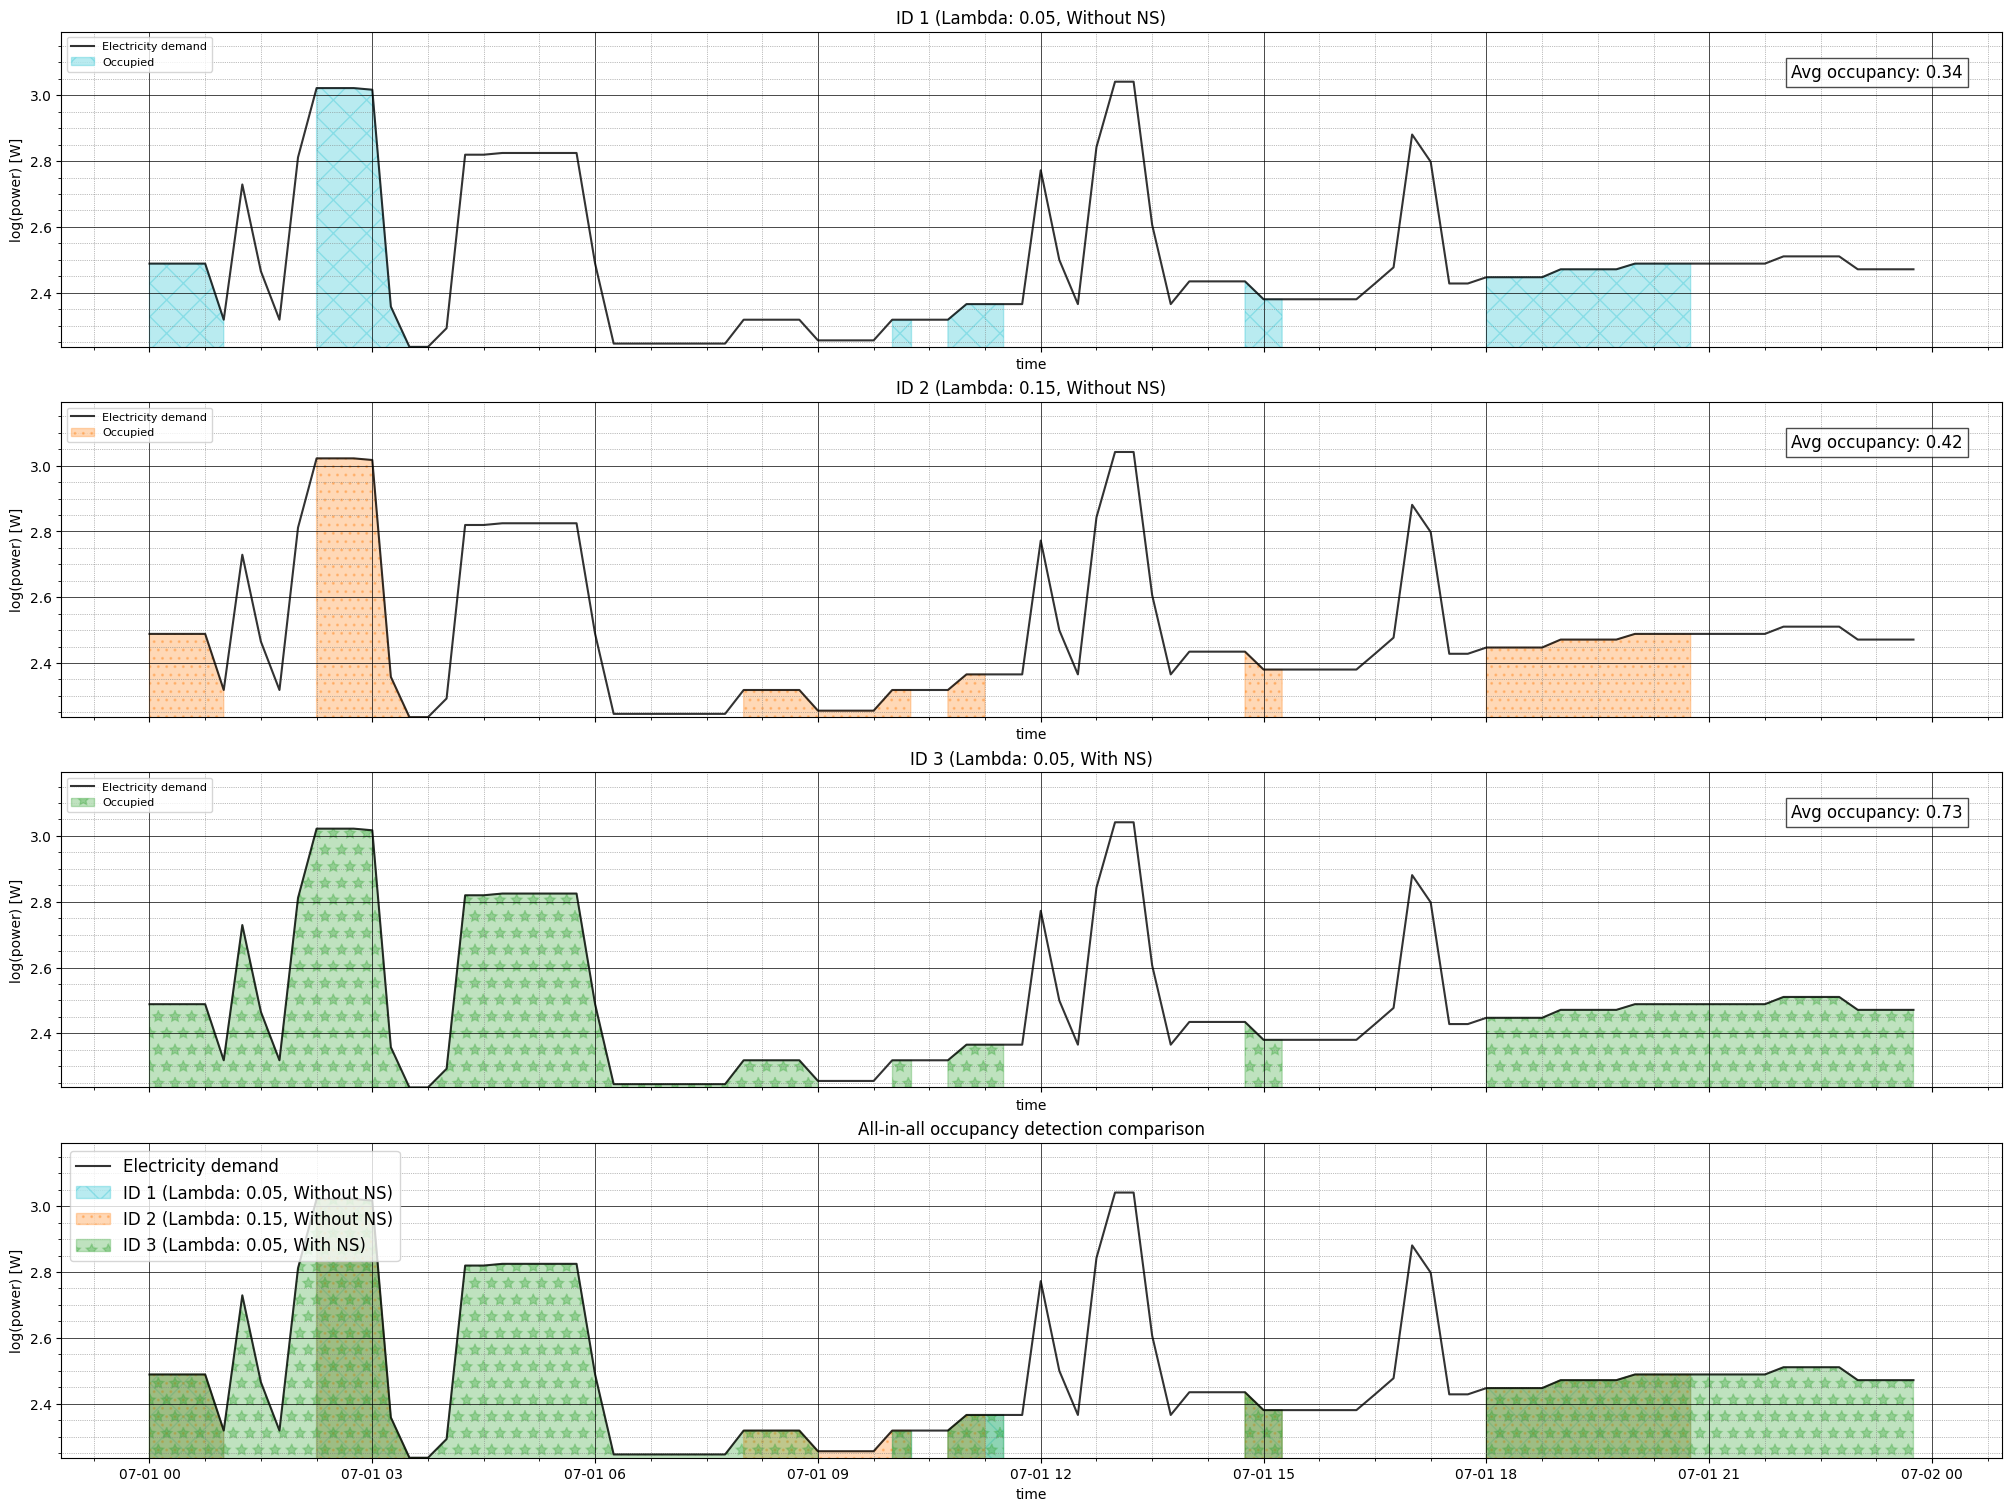

In [7]:
fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(20, 15), sharex=True, constrained_layout=True)

def style_ax(ax, title, ymin):
    ax.set_title(title, fontsize=12)
    ax.set_xlabel("time", fontsize=10)
    ax.set_ylabel("log(power) [W]", fontsize=10)
    ax.set_ylim(bottom=ymin)
    ax.minorticks_on()
    ax.grid(which="major", linestyle="-", linewidth=0.5, color="black")
    ax.grid(which="minor", linestyle=":", linewidth=0.5, color="gray")

def plot_object_data(ax, df, cfg, show_legend=True):
    """Plot electricity demand and occupancy for a single object"""
    log_power = np.log10(df[Types.ELECTRICITY][Columns.POWER])
    occupancy_col = f"{Types.OCCUPANCY}{SEP}{Columns.OCCUPANCY}"

    # Plot electricity demand
    ax.plot(df[Types.OCCUPANCY].index, log_power, color="black", alpha=0.8)

    # Fill occupied periods
    ax.fill_between(
        df[Types.OCCUPANCY].index, log_power,
        where=df[Types.OCCUPANCY][occupancy_col] == 1,
        color=cfg["color"], hatch=cfg["texture"], alpha=0.3
    )

    # Style and legend
    style_ax(ax, cfg["legend"], log_power.min())
    if show_legend:
        ax.legend(["Electricity demand", "Occupied"], fontsize=8, loc="upper left")

    # Add average occupancy text
    avg_occ = df[Types.OCCUPANCY][occupancy_col].mean().round(2)
    ax.text(0.98, 0.9, f"Avg occupancy: {avg_occ}",
            transform=ax.transAxes, ha="right", va="top",
            bbox=dict(facecolor="white", alpha=0.7), fontsize=12)

# Plot individual objects (IDs 1-3)
dfs_list = [df_1, df_2, df_3]
for i, (df, obj_id) in enumerate(zip(dfs_list, [1, 2, 3])):
    plot_object_data(axs[i], df, OBJECT_CONFIGS[obj_id])

# All-in-all comparison plot
ax = axs[3]
ax.plot(df_1[Types.OCCUPANCY].index,
        np.log10(df_1[Types.ELECTRICITY][Columns.POWER]),
        color="black", alpha=0.8)

# Fill between for all objects
occupancy_col = f"{Types.OCCUPANCY}{SEP}{Columns.OCCUPANCY}"
for df, obj_id in zip(dfs_list, [1, 2, 3]):
    ax.fill_between(
        df[Types.OCCUPANCY].index,
        np.log10(df[Types.ELECTRICITY][Columns.POWER]),
        where=df[Types.OCCUPANCY][occupancy_col] == 1,
        color=OBJECT_CONFIGS[obj_id]["color"],
        hatch=OBJECT_CONFIGS[obj_id]["texture"],
        alpha=0.3
    )

style_ax(ax, "All-in-all occupancy detection comparison",
         np.log10(df_1[Types.ELECTRICITY][Columns.POWER]).min())
ax.legend(["Electricity demand"] + [OBJECT_CONFIGS[i]["legend"] for i in [1, 2, 3]],
          fontsize=12, loc="upper left")

plt.show()

### Plot 2: All in All Monthly Average

Shows the monthly percentage of occupancy for the 3 different objects. Notably, Object with ID= 3 has the highest occupancy rate, heavily influenced by the use of the nightly schedule detection algorithm.

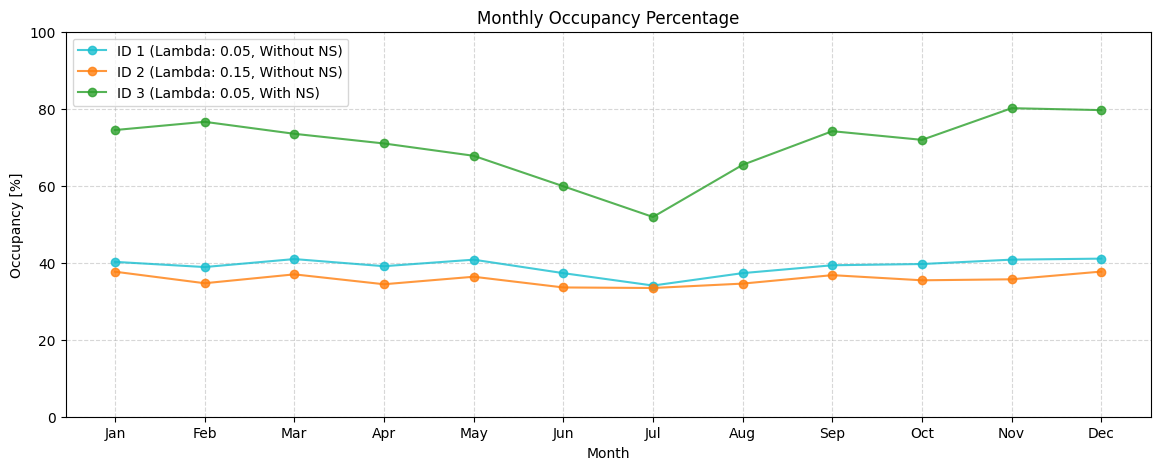

In [8]:
fig, ax = plt.subplots(figsize=(14, 5))

for obj_id, cfg in OBJECT_CONFIGS.items():

    occ = dfs[obj_id][Types.OCCUPANCY]

    occ.index = pd.to_datetime(occ.index,utc=True).tz_convert("Europe/Berlin")

    monthly_occ = (
        occ[f"{Types.OCCUPANCY}{SEP}{Columns.OCCUPANCY}"]
        .groupby(occ.index.month)
        .mean()
        .mul(100)
        .sort_index()
    )

    ax.plot(
        monthly_occ.index,
        monthly_occ.values,
        marker="o",
        label=cfg["legend"],
        color=cfg["color"],
        alpha=0.8,
    )

ax.set_title("Monthly Occupancy Percentage", fontsize=12)
ax.set_xlabel("Month")
ax.set_ylabel("Occupancy [%]")
ax.set_ylim(0, 100)
ax.grid(True, which="both", linestyle="--", alpha=0.5)
ax.set_xticks(range(1, 13))
ax.set_xticklabels(
    ["Jan", "Feb", "Mar", "Apr", "May", "Jun",
     "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
)
ax.legend(fontsize=10, loc="upper left")

plt.show()

## Next Steps
You can further:
- Explore the effect on different seasons of the year.
- Apply higher or lower lambda values,
- or different nightly schedule configurations.
- Explore the effect that electricity demands with different time resolution have on the detected occupancy.